# Environment Setup
- api key 각자 로컬에 셋업 

In [45]:
from langchain import LLMChain, PromptTemplate
from langchain.llms import OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

import psycopg2 as pg
import os


with open('open_api_key.txt', 'r') as f:
    openai_key = f.read().strip()

#모델, 아웃풋 파싱 준비
model = ChatOpenAI(model="gpt-4", api_key=openai_key)
parser = StrOutputParser()

# Get Activity From Github, X, and Mainnet 
B0 ~ B7 on Diagram

In [ ]:
# def github_api_request(owner, repo, endpoint=None, params={}):
#     if endpoint:
#         base_url = f'https://api.github.com/repos/{owner}/{repo}/{endpoint}'
#     else:
#         base_url = f'https://api.github.com/repos/{owner}/{repo}'
#     response = requests.get(base_url, params=params)
#     return response.json()

# def count_commits(owner, repo, params={}):
#     commits = github_api_request(owner, repo, 'commits', params)
#     return len(commits)

# def count_issues(owner, repo, params={}):
#     issues_data = github_api_request(owner, repo, 'issues', params)
#     issue_count = len([issue for issue in issues_data if 'pull_request' not in issue])
#     return issue_count

# def count_pull_requests(owner, repo, params={}):
#     pulls = github_api_request(owner, repo, 'pulls', params)
#     return len(pulls)

# def count_watcher(owner, repo, parmas={}):
#     repo = github_api_request(owner, repo, '')
#     print(repo)
#     return repo['watchers_count']

In [1]:
import requests
from datetime import datetime, timedelta
from pprint import pprint
import json
import psycopg2 as pg
from psycopg2 import sql
import SQLScript as SS
import uuid

In [7]:
# to take the github repo data
# 지금은 github에서 db를 안거치고 이 노트북에 업로드 되는데, 
# db를 거쳐서 적재된 후에, 
# 다시 로딩되는 형태로 만드는 부분을 이 곳에다가 apply 할것. 

def github_api_request(owner, repo, params=params):
    # API 요청을 한 번만 수행하여 repo 관련 데이터를 저장
    base_url = f'https://api.github.com/repos/{owner}/{repo}'
    response_repo = requests.get(base_url, params=params)
    repo_data = response_repo.json()

    commits_url = f'https://api.github.com/repos/{owner}/{repo}/commits'
    response_commits = requests.get(commits_url)
    commits_data = response_commits.json()

    issues_url = f'https://api.github.com/repos/{owner}/{repo}/issues'
    response_issues = requests.get(issues_url)
    issues_data = response_issues.json()

    pulls_url = f'https://api.github.com/repos/{owner}/{repo}/pulls'
    response_pulls = requests.get(pulls_url)
    pulls_data = response_pulls.json()

    return {
        'repo': repo_data,
        'commits': commits_data,
        'issues': issues_data,
        'pulls': pulls_data
    }

# 각 함수에서 저장된 JSON 데이터를 활용하도록 수정
def count_commits(github_data):
    return len(github_data['commits'])

def count_issues(github_data):
    issue_count = len([issue for issue in github_data['issues'] if 'pull_request' not in issue])
    return issue_count

def count_pull_requests(github_data):
    return len(github_data['pulls'])

def count_watchers(github_data):
    return github_data['repo']['watchers_count']

# X 데이터도 마찬가지로 DB로 읽어온 다음, 여기에 로딩되고
# pandas 형태로 깃헙과 x activity를 불러와야 되겠지..? 
# where문 써서, 우리가 원하는 프로젝트만 불러오는게 필요할 수 있겠다.  

# Scoring Algorithm(s)
Counts Activity. Currently Measured Daily. 

In [8]:
# set the owner and repo
owner = 'courtyard-nft'
repo = 'go-shippo'

# get the diff between today and month
git_today = datetime.utcnow()
last_month = git_today - timedelta(days=30)

# change the datetime foramt as ISO 8601
since = last_month.isoformat() + 'Z'
until = git_today.isoformat() + 'Z'

# request the number of Commits
params = {'since': since, 'until': until}
params2 = {'since': since, 'until': until}
params3 = {'since': since, 'until': until}
git_data = github_api_request(owner, repo, params=params)
# print(git_data)
before_git_data = github_api_request(owner, repo, params=params2)
after_git_data =  github_api_request(owner, repo, params=params3)
commit_count = count_commits(git_data)
print(f"Commits in the last day: {commit_count}")

# request the number of Issues
issue_count = count_issues(git_data)
print(f"Issues in the last day: {issue_count}")

# request the number of Pull Requests
pull_count = count_pull_requests(git_data)
print(f"Pull Requests in the last day: {pull_count}")

# request the number of Watchers
before_month_watcher_count = count_watchers(before_git_data)
after_month_watcher_count = count_watchers(after_git_data)

watcher_diff = after_month_watcher_count - before_month_watcher_count
print(f"Watchers in the last day: {watcher_diff}")

git_date_time = git_today

C:\Users\power\AppData\Local\Temp\ipykernel_14224\505456302.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  git_today = datetime.utcnow()


Commits in the last day: 30
Issues in the last day: 0
Pull Requests in the last day: 0
Watchers in the last day: 0


In [12]:
git_data['repo']

{'id': 595299598,
 'node_id': 'R_kgDOI3uNDg',
 'name': 'go-shippo',
 'full_name': 'courtyard-nft/go-shippo',
 'private': False,
 'owner': {'login': 'courtyard-nft',
  'id': 88097356,
  'node_id': 'MDEyOk9yZ2FuaXphdGlvbjg4MDk3MzU2',
  'avatar_url': 'https://avatars.githubusercontent.com/u/88097356?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/courtyard-nft',
  'html_url': 'https://github.com/courtyard-nft',
  'followers_url': 'https://api.github.com/users/courtyard-nft/followers',
  'following_url': 'https://api.github.com/users/courtyard-nft/following{/other_user}',
  'gists_url': 'https://api.github.com/users/courtyard-nft/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/courtyard-nft/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/courtyard-nft/subscriptions',
  'organizations_url': 'https://api.github.com/users/courtyard-nft/orgs',
  'repos_url': 'https://api.github.com/users/courtyard-nft/repos',
  'events_url': 'htt

In [ ]:
conn = SS.SQL_tools()

In [76]:
project_id = str(uuid.uuid4())
project_name = 'courtyard_io'
github_repo_id = str(uuid.uuid4())

project_df = {
    "project_id" : project_id,
    "project_name" : project_name,
    "create_date" : git_date_time,
    "recent_action_date" : git_date_time
}

git_repo_df = {
    "project_id" : project_id,
    "github_repo_id" : github_repo_id,
    "owner_name" : owner,
    "github_repo": repo
}

git_df = {
    "github_repo_id" : github_repo_id,
    "commit_count" : commit_count,
    "issue_count" : issue_count,
    "pr_count" : pull_count,
    "watcher_count" : watcher_diff,
    "datetime" : git_date_time
}
project_df_table = "project"
git_repo_df_table = "githubrepos"
git_df_table = "githubrepoactivitylog"


## 트위터에 대한 데이터가 print되어서 나오게 하기 - 경재! 

## pandas 하기 

In [77]:
conn.insert_to_db(project_df_table, project_df)
conn.insert_to_db(git_repo_df_table, git_repo_df)
conn.insert_to_db(git_df_table, git_df)

ForeignKeyViolation: insert or update on table "githubrepoactivitylog" violates foreign key constraint "githubrepoactivitylog_github_repo_id_fkey"
DETAIL:  Key (github_repo_id)=(b0d1cff3-e11e-4f4c-92cb-d297a7473348) is not present in table "githubrepos".


# Frontend Begins HERE! 
the users (subject matter experts) should interact here. 

# Rule Based Classification; LLM-As a Judge Prompt 
Based on the activity data we gatherd above, now we judge if project is dying. 
You can change the thresholds and other details in prompt.
It's defined in 'system_template' variable.

In [42]:
### 예진님: 리포트를 예쁘게 만들어내 봅시다 

system_template = """
You should rate the project based on the following criteria, 
but at this time, only the github information will be suggested. 
and if the score is less than 15, you should consider the project as dead.
Unless, you should consider the project as alive.
and you should make the report based on your own opinion for the project. 
:

### scoring criteria

1. GitHub Score (30 points total)

Frequency of commits:

- more than 20 commits within last month : 12 points
- more than 10 commits within last month  : 9 points
- Less than three commits within last month: 3 points
- No commits for more than 1 months: 0 points

Number of increased watchers:

- 5 or more increased : 9 points
- 3-4 increased : 6 points
- 1-2 increased : 3 points
- Not increased : 0 points

Issues and pull request activity:

- Frequent activity (discussions, quick resolutions within 1-2 weeks): 9 points
- Moderate activity (some unresolved issues, resolutions taking longer): 6 points
- Minimal activity (many unresolved issues, responses taking months): 3 points
- No issue or pull request activity: 0 points

### data
{data}

### report example 
based on the data,  i would rate 
.... 
declare dead. 

"""

data_input = f"""
commits in last month: {commit_count}
issues in last month: {issue_count}
pull request activity: {pull_count}
increased watchers: {watcher_diff}

"""

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{data}")]
)
chain = prompt_template | model | parser

Execute Below to see the results

In [ ]:
result = chain.invoke({"data": data_input})
print(result)

# Handling Different Project Cases 
Let's say, we don't want to judge a project in very early stage with the same standards with a project that went live long ago. 
Also, Art or community related projects should be held to different standards then software product based projects. 
We use LLM agent to comprehend the project description, then route them to appropriate prompt templates. Each prompt templates have fitting standards for judgement.  


In [ ]:
# 분기하는 경우의 프롬프트 

prompt_template_for_coding_scoring = """
1. GitHub Score (30 points total)

Frequency of commits:

- more than 20 commits within last month : 12 points
- more than 10 commits within last month  : 9 points
- Less than three commits within last month: 3 points
- No commits for more than 1 months: 0 points

2. Twitter Score
Engagement Metrics: 12 points

Frequency of posts : 9 points 


3. Near Score


"""


prompt_template_for_non_coding_scoring = """
1. Twitter Score
Engagement Metrics: 30 points

Frequency of posts : 40 points 
"""

Execute below to see evaluation results. 

In [51]:
result = chain.invoke({"data": data_input})
print(result)

Based on the given data, I would score the project as follows:

Frequency of commits: No commits for more than 1 month, so 0 points.

Number of increased watchers: No increased watchers, so 0 points.

Issues and pull request activity: Given the number of issues and pull request activity, it seems there is frequent activity. However, without knowing the speed of resolution, it's difficult to accurately score this. If we assume quick resolutions, this would be 9 points. 

Therefore, the total GitHub score for this project is 9 points. Since this score is less than 15, I would consider the project as dead. However, the high degree of issues and pull request activity does suggest that there may still be interest and activity within the project, so it might be worth investigating further before making a final decision.


# Project Activity Data Dashboard
Social Data Dashboard: Trend, numbers and predictions



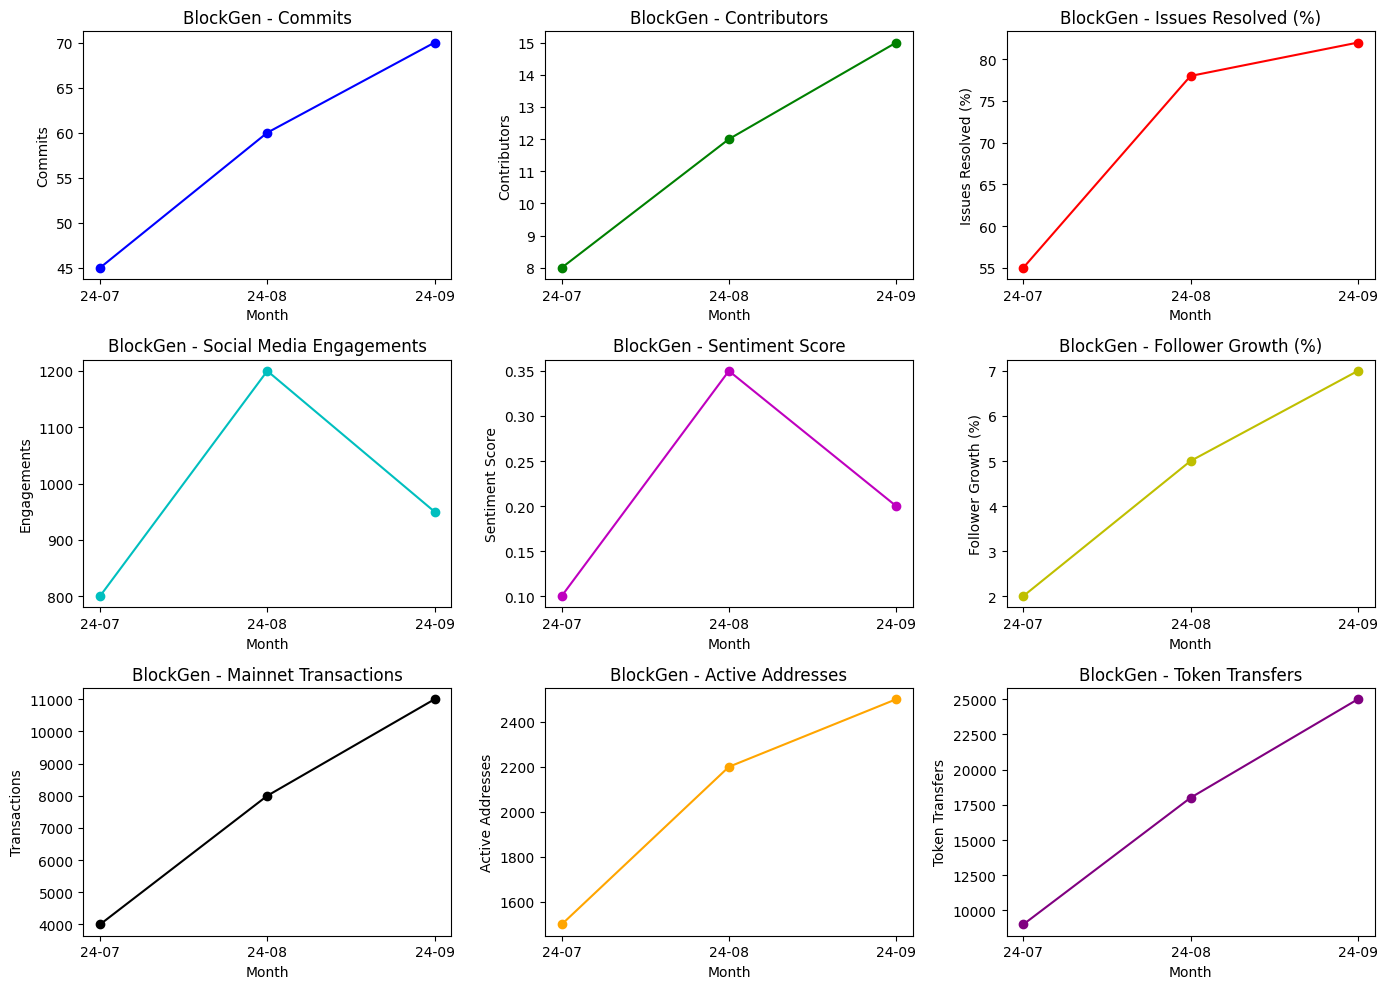

In [54]:
#경재가 할 부분! 대시보드 대충 만들기 
# 지금 있는건 placeholder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hypothetical data for a blockchain project
project_name = "BlockGen"

# Time axis (3 months)
months = ['24-07', '24-08', '24-09']

# Sample data
data = {
    'Commits': [45, 60, 70],  # Monthly commits
    'Contributors': [8, 12, 15],  # Number of contributors
    'Issues Resolved (%)': [55, 78, 82],  # Percentage of issues resolved within 30 days
    'Engagements': [800, 1200, 950],  # Social media engagements
    'Sentiment Score': [0.1, 0.35, 0.2],  # Social media sentiment score
    'Follower Growth (%)': [2, 5, 7],  # Social media follower growth rate
    'Transactions': [4000, 8000, 11000],  # Mainnet transactions per month
    'Active Addresses': [1500, 2200, 2500],  # Active addresses per month
    'Token Transfers': [9000, 18000, 25000]  # Token transfers per month
}

# Convert data to DataFrame
df = pd.DataFrame(data, index=months)

# Plotting the graphs
plt.figure(figsize=(14, 10))

# Commits plot
plt.subplot(3, 3, 1)
plt.plot(df.index, df['Commits'], marker='o', color='b')
plt.title(f"{project_name} - Commits")
plt.xlabel('Month')
plt.ylabel('Commits')

# Contributors plot
plt.subplot(3, 3, 2)
plt.plot(df.index, df['Contributors'], marker='o', color='g')
plt.title(f"{project_name} - Contributors")
plt.xlabel('Month')
plt.ylabel('Contributors')

# Issues Resolved plot
plt.subplot(3, 3, 3)
plt.plot(df.index, df['Issues Resolved (%)'], marker='o', color='r')
plt.title(f"{project_name} - Issues Resolved (%)")
plt.xlabel('Month')
plt.ylabel('Issues Resolved (%)')

# Social Media Engagement plot
plt.subplot(3, 3, 4)
plt.plot(df.index, df['Engagements'], marker='o', color='c')
plt.title(f"{project_name} - Social Media Engagements")
plt.xlabel('Month')
plt.ylabel('Engagements')

# Sentiment Score plot
plt.subplot(3, 3, 5)
plt.plot(df.index, df['Sentiment Score'], marker='o', color='m')
plt.title(f"{project_name} - Sentiment Score")
plt.xlabel('Month')
plt.ylabel('Sentiment Score')

# Follower Growth plot
plt.subplot(3, 3, 6)
plt.plot(df.index, df['Follower Growth (%)'], marker='o', color='y')
plt.title(f"{project_name} - Follower Growth (%)")
plt.xlabel('Month')
plt.ylabel('Follower Growth (%)')

# Transactions plot
plt.subplot(3, 3, 7)
plt.plot(df.index, df['Transactions'], marker='o', color='k')
plt.title(f"{project_name} - Mainnet Transactions")
plt.xlabel('Month')
plt.ylabel('Transactions')

# Active Addresses plot
plt.subplot(3, 3, 8)
plt.plot(df.index, df['Active Addresses'], marker='o', color='orange')
plt.title(f"{project_name} - Active Addresses")
plt.xlabel('Month')
plt.ylabel('Active Addresses')

# Token Transfers plot
plt.subplot(3, 3, 9)
plt.plot(df.index, df['Token Transfers'], marker='o', color='purple')
plt.title(f"{project_name} - Token Transfers")
plt.xlabel('Month')
plt.ylabel('Token Transfers')

plt.tight_layout()
plt.show()

# Call to Action: Alert, Adjust Token streaming Rate 
Next step on the roadmap: to integrate with existing smart contracts. 
For example, the LLM could adjust token streaming rate for on-chain contract. 


In [ ]:
def alert_the_watchers (dead_or_alive):
    print("Alert!")

# Suggested Evaluation Threshold for Rule based approach: 


Based on 
- Data on average commit counts and contributor distributions are derived from **studies on GitHub’s public repositories**, including blockchain-specific projects.
- Social media engagement metrics are based on **typical ranges observed in crypto community analytics and social media benchmarking reports**.
- Mainnet transaction volumes and active address counts were informed by blockchain analytics from mid-tier to popular blockchain projects, as observed in platforms like Etherscan, Dune Analytics, and other blockchain explorer data


1. Github Metrics: 
Commit Frequency Thresholds:

High (> 50 commits/month): Projects with consistent, high commit rates are typically under active development. According to data on open-source repositories, the median commit count per month for actively maintained repositories is around 50 commits. Blockchain projects that surpass this are considered highly active.
Moderate (20-50 commits/month): This range captures projects that are steadily maintained but might not be under intense development. The 20-50 range represents the interquartile range for many active blockchain projects.
Low (< 20 commits/month): Projects with fewer than 20 commits per month are often in maintenance mode or seeing reduced activity. This threshold aligns with the lower quartile of commit activity seen across many GitHub repositories.
Contributor Count Thresholds:

High (> 10 contributors): Active blockchain projects often involve multiple developers. Data from open-source software (OSS) projects indicates that successful and actively maintained projects usually have at least 10 contributors.
Moderate (5-10 contributors): This range represents moderately collaborative projects, still maintaining sufficient contributor engagement.
Low (< 5 contributors): Projects with fewer than 5 active contributors often indicate limited engagement, which is common in smaller or declining projects.

Issue and Pull Request Management Thresholds:

High Responsiveness (80%+ resolved in 30 days): A study on OSS repositories shows that well-maintained projects resolve the majority of issues quickly, with 80% or more closed within a month.
Moderate Responsiveness (50-80% resolved): Represents adequate maintenance; still actively managed but not as promptly.
Low Responsiveness (< 50% resolved): Slow resolution rates often signify stalled or struggling projects.
Forks and Stars:

Growing, stable, and declining trends are based on changes observed over a 6-month period, with active projects generally showing a steady increase in forks and stars as proxies for interest and adoption.

2. Social Media (X/Twitter) Metrics:

Engagement Metrics:

High (> 1000 engagements/month): Top-performing blockchain projects tend to have high visibility, with notable engagement rates. For active blockchain projects, 1000 engagements per month (including likes, retweets, replies) represents a strong level of community interaction.
Moderate (500-1000 engagements/month): Reflects decent engagement and a still-active community.
Low (< 500 engagements/month): Often indicates limited reach or waning interest, common for smaller or less visible projects.

Sentiment Analysis:

Positive (> 0.3 average score): Sentiment analysis tools classify above 0.3 as generally positive, which is typical for thriving communities.
Neutral (-0.3 to 0.3): Mixed or balanced sentiment is indicative of a stable but not overly enthusiastic community.
Negative (< -0.3): Projects facing issues often attract negative sentiment, which can be a sign of underlying problems.

Follower Growth:

High Growth (> 5%/month): Reflects growing popularity and increasing community size, aligned with successful projects.
Moderate Growth (1-5%/month): Indicates steady growth, sufficient to suggest ongoing interest.
Low Growth (< 1%/month): Stagnant or declining follower counts can indicate declining project momentum.

3. Mainnet Transactions and On-Chain Activity Metrics:

Mainnet Transaction Volume: 

High (> 10,000 transactions/month): For blockchain projects with active usage, this figure represents the average seen in mid-tier blockchain networks. Larger projects often exceed this by a significant margin.
Moderate (5,000-10,000 transactions/month): This range captures moderate usage levels, typical for projects with a specific niche or less frequent interactions.
Low (< 5,000 transactions/month): Projects with fewer than 5,000 transactions per month are generally underused, often seen in struggling or less-adopted networks.

Active Addresses:

High (> 2,000 addresses/month): Represents a healthy user base engaging with the blockchain, as seen in moderately successful blockchain ecosystems.
Moderate (1,000-2,000 addresses/month): Indicates moderate engagement, sufficient to maintain activity but not indicative of high growth.
Low (< 1,000 addresses/month): Common in smaller or declining networks, signaling reduced user interaction.
Token Circulation and Transfers:

High (> 20,000 transfers/month): High token movement suggests active trading or usage within the ecosystem.
Moderate (10,000-20,000 transfers/month): Indicates ongoing but not extensive token usage.
Low (< 10,000 transfers/month): Often reflects a lack of user engagement or low network activity.


# Inference Evaluation for Rule Based Classification
How Well does model perform? Compare y and y'
(실 데이터가 갖추어진 뒤 실행)

In [ ]:
print("hello world")

# Suggested Analysis  

## Benchmarking Against Competitors: 
Compare the project’s metrics with those of similar projects or competitors to contextualize the performance. 

## Historical Trend Analysis
Time series Analysis



In [ ]:
deleteThis = "hello world"